In [1]:
DATA_FILE="/zfs/safrolab/users/jsybran/bridgeSim/results/cleanCarData.mat"
DATA_NAME="data"
START_IDX=0
END_IDX=-4
VAL_IDX=-1
MASS_IDX=21
DAY_INX=22
NUM_LABELS=3
MIN_MASS=0
import scipy.io as sio
import numpy as np
import tensorflow.contrib.learn as skflow
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import os.path

tf.logging.set_verbosity(tf.logging.INFO)

if not os.path.isfile(DATA_FILE):
    raise ValueError("Aint data")

In [14]:
#LOAD MATRIX
matData = sio.loadmat(DATA_FILE)
matrix = np.asmatrix(matData[DATA_NAME])  
num_examples, total_col = matrix.shape
print(matrix.shape)
# SUBSET
validRows = matrix[:, MASS_IDX] > MIN_MASS
num_examples = np.sum(validRows)
matrix = matrix[validRows * [True for i in range(total_col)]]
matrix = matrix.reshape(num_examples, total_col)
print(matrix.shape)

(259218, 26)
(242898, 26)


In [3]:
# SUBSAMPLE CLASSES EVENLY
num_samples_per_label = 50000
e_mat = np.zeros((num_samples_per_label * NUM_LABELS, total_col))
for l in range(NUM_LABELS):
    l_mat = matrix[(matrix[:, VAL_IDX] == l) * [True for i in range(total_col)]].reshape(-1, total_col)
    print(l_mat.shape)
    np.random.shuffle(l_mat)
    e_mat[l*num_samples_per_label:(l+1)*num_samples_per_label, :] = l_mat[0:num_samples_per_label]
matrix = np.asmatrix(e_mat)

(72054, 26)
(53163, 26)
(117681, 26)


In [6]:

X = matrix[:, START_IDX:END_IDX].astype(np.float32)
Y = matrix[:, VAL_IDX].astype(int)
print(X.shape)
print(Y.shape)
num_examples, num_features = X.shape
assert((num_examples, 1) == Y.shape)
# Each column is a feature
# Each row is an example

(16101, 22)
(16101, 1)


In [7]:
#LOAD MODEL
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=num_features)]
MODEL_PATH = "/zfs/safrolab/users/jsybran/bridgeSim/results/tf_model"

classifier = skflow.DNNClassifier(
    [num_features, num_features*2, num_features*2, num_features],
    feature_columns,  n_classes=NUM_LABELS, model_dir=MODEL_PATH)

# watch me with tensorboard --logdir=/tmp/bridge_model

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_evaluation_master': '', '_model_dir': '/zfs/safrolab/users/jsybran/bridgeSim/results/tf_model', '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_master': '', '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2b6aad4166a0>, '_environment': 'local', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_log_step_count_steps': 100, '_session_config': None, '_task_type': None, '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_num_worker_replicas': 0, '_keep_checkpoint_max': 5, '_task_id': 0, '_tf_random_seed': None}


In [235]:
classifier.fit(X, Y, steps=1000, batch_size=10000)
results = classifier.evaluate(X, Y)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /zfs/safrolab/users/jsybran/bridgeSim/results/tf_model/model.ckpt-800000
INFO:tensorflow:Saving checkpoints for 800001 into /zfs/safrolab/users/jsybran/bridgeSim/results/tf_model/model.ckpt.
INFO:tensorflow:loss = 0.888656, step = 800001
INFO:tensorflow:global_step/sec: 22.136
INFO:tensorflow:loss = 0.890544, step = 800101 (4.519 sec)
INFO:tensorflow:global_step/sec: 22.1279
INFO:tensorflow:loss = 0.880698, step = 800201 (4.519 sec)
INFO:tensorflow:global_step/sec: 22.2183
INFO:tensorflow:loss = 0.886119, step = 800301 (4.501 sec)
INFO:tensorflow:global_step/sec: 22.2175
INFO:tensorflow:loss = 0.889685, step = 800401 (4.501 sec)
INFO:tensorflow:global_step/sec: 22.123
INFO:tensorflow:loss = 0.895244, step = 800501 (4.520 sec)
INFO:tensorflow:global_step/sec: 22.0973
INFO:tensorflow:loss = 0.896377, step = 800601 (4.525 sec)
INFO:tensorflow:global_step/sec: 22.1154
INFO:tensorflow:loss = 0.881188, step

In [230]:
print(results)

{'loss': 0.89069498, 'accuracy': 0.55696666, 'global_step': 800000}


In [15]:
max_mass = np.amax(matrix[:, MASS_IDX])
cols = matrix.shape[1]
matrix = matrix[(matrix[:, MASS_IDX] == max_mass) * [True for i in range(cols)]].reshape((-1,cols))
X = matrix[:, START_IDX:END_IDX].astype(np.float32)
Y = matrix[:, VAL_IDX].astype(int)

exact = 0
close = 0
total = 0
for i, (a, b) in enumerate(zip(classifier.predict(X), Y)):
    if a == b:
        exact += 1
    if (a == 0) == (b == 0):
        close += 1
    total += 1
    
print(exact / total, exact, total)

print(close / total, close, total)

INFO:tensorflow:Restoring parameters from /zfs/safrolab/users/jsybran/bridgeSim/results/tf_model/model.ckpt-801000
0.6658305292138269 10883 16345
0.7949831752829611 12994 16345


In [16]:


days = [x[0] for x in matrix[:, DAY_INX].tolist()]
predictions = [p for p in classifier.predict(X)]
reality = [y[0] for y in Y.tolist()]

real_points = list(set(zip(days, reality)))
real_days = [p[0] for p in real_points]
real_vals = [p[1] for p in real_points]

points = list(set(zip(days, predictions)))
day2count = {}
for day in days:
    if day not in day2count:
        day2count[day] = 1
    else:
        day2count[day] += 1
        
point2count = {}
for point in zip(days, predictions):
    if point not in point2count:
        point2count[point] = 1
    else:
        point2count[point] += 1
        
        
day2majority = {}
MAX_POINT_SIZE=80
for day, pred in points:
    count = 0
    label = -1
    for l in range(NUM_LABELS):
        if (day, l) in point2count and point2count[(day, l)] > count:
            count = point2count[(day, l)]
            label = l
    day2majority[day] = label
        
counts = [MAX_POINT_SIZE * point2count[p]/day2count[p[0]]
          for p in points]

majority_predictions = [day2majority[d] for d in days]

INFO:tensorflow:Restoring parameters from /zfs/safrolab/users/jsybran/bridgeSim/results/tf_model/model.ckpt-801000


In [17]:

fig = plt.figure(figsize=(15, 4), dpi= 80)
ax = plt.axes()

ax.scatter(real_days, real_vals, 8*MAX_POINT_SIZE, marker="s", color="black")
ax.scatter(days, majority_predictions, 4*MAX_POINT_SIZE, marker='s', color="red")
ax.scatter(days, predictions, counts)

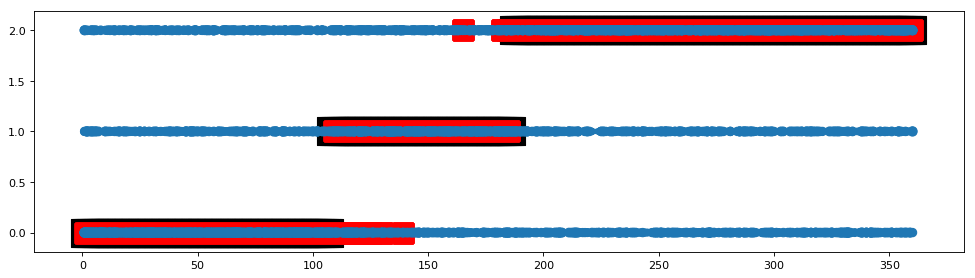

In [18]:
plt.show()

1	33	4	7
2	32	11	5
3	18	6	2
4	31	6	6
5	32	6	5
6	36	6	7
7	26	7	5
8	34	3	6
9	25	3	3
10	33	8	5
11	33	8	5
12	42	9	11
13	35	9	5
14	30	5	6
15	32	7	5
16	29	6	7
17	24	6	8
18	28	9	8
19	32	9	4
20	29	13	7
21	38	6	7
22	27	8	8
23	39	10	5
24	33	4	14
25	23	9	10
26	32	4	7
27	23	8	8
28	35	1	8
29	36	6	14
30	33	7	7
31	39	9	9
32	28	8	9
33	39	6	9
34	32	1	3
35	27	8	6
36	38	7	14
37	29	4	2
38	39	9	7
39	28	7	6
40	37	8	6
41	27	10	4
42	30	8	5
43	33	5	5
44	28	7	8
45	28	9	4
46	31	7	7
47	33	11	3
48	29	10	7
49	43	3	9
50	25	7	3
51	34	6	4
52	32	8	5
53	32	5	10
54	31	7	6
55	33	8	9
56	35	3	6
57	18	11	12
58	27	7	3
59	31	9	7
60	32	6	1
61	24	4	10
62	33	5	10
63	41	2	3
64	33	9	9
65	35	7	6
66	45	6	6
67	36	7	1
68	28	10	5
69	29	3	6
70	25	8	10
71	33	8	4
72	38	9	3
73	38	11	11
74	32	10	5
75	21	4	6
76	34	7	9
77	27	6	7
78	26	8	6
79	28	10	8
80	36	7	8
81	25	4	9
82	35	5	4
83	26	5	8
84	34	11	5
85	32	6	5
86	20	2	5
87	35	8	4
88	29	7	9
89	33	6	5
90	39	9	6
91	25	5	7
92	37	7	7
93	43	4	5
94	34	13	7
95	37	4	6
96	32	7	6
97	35	10	4
98	36	8	4
99	3

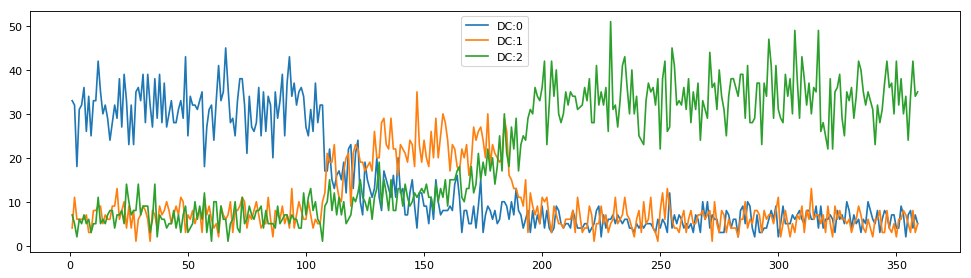

In [19]:
d = []
a = []
b = []
c = []
for day in range(1, 360):
    try:
        print("{}\t{}\t{}\t{}".format(
            day,
            point2count[(day, 0)],
            point2count[(day, 1)],
            point2count[(day, 2)]))
        d.append(day)
        a.append(point2count[(day, 0)])
        b.append(point2count[(day, 1)])
        c.append(point2count[(day, 2)])
    except:
        pass
    
fig = plt.figure(figsize=(15, 4), dpi= 80)
ax = plt.axes()

ax.plot(d, a, label="DC:0")
ax.plot(d, b, label="DC:1")
ax.plot(d, c, label="DC:2")
ax.legend()
plt.show()

In [169]:
numDays = int(np.ceil(max(np.unique(np.asarray(matrix[:, DAY_INX])))))+1
numDistinctMasses = 11
day2summary = np.zeros((numDays, numDistinctMasses*NUM_LABELS+2))  # 3 for each mass, day and result

n_mat = np.asmatrix(np.copy(matrix))
X = n_mat[:, START_IDX:END_IDX].astype(np.float32)
n_mat[:, VAL_IDX] = np.asmatrix([y for y in classifier.predict(X)]).T

print(n_mat.shape)

for day in np.asarray(np.unique(np.asarray(n_mat[:, DAY_INX]))):
    day = int(day)
    cols = n_mat.shape[1]
    dayData = n_mat[(n_mat[:, DAY_INX] == 1) * [True for i in range(cols)]].reshape((-1,cols))

    for m in range(numDistinctMasses):
        massData = dayData[(np.floor(dayData[:, MASS_IDX]*10) == m) * [True for i in range(cols)]].reshape((-1,cols))
        if massData.shape[0] == 0:
            continue
        for l in range(NUM_LABELS):
            labelCount = sum(massData[:, VAL_IDX] == l)
            day2summary[day, m * NUM_LABELS + l] = labelCount / dayData.shape[0]
    day2summary[day, -2] = day
    day2summary[day, -1] = np.amax(Y[matrix[:, DAY_INX] == day]) # TRUTH

INFO:tensorflow:Restoring parameters from /zfs/safrolab/users/jsybran/bridgeSim/results/tf_model/model.ckpt-1720314
(60000, 26)


In [170]:
SUMMARY_MODEL_PATH = "/zfs/safrolab/users/jsybran/bridgeSim/results/tf_summary_model"
sum_feature_columns = [tf.contrib.layers.real_valued_column("", dimension=NUM_LABELS+1)]

X = day2summary[:, :-2].astype(np.float32)
Y = day2summary[:, -1].astype(int)

summary_classifier = skflow.DNNClassifier(
    [NUM_LABELS*numDistinctMasses],
    sum_feature_columns,  n_classes=NUM_LABELS, model_dir=SUMMARY_MODEL_PATH)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_id': 0, '_is_chief': True, '_log_step_count_steps': 100, '_num_worker_replicas': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_master': '', '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_environment': 'local', '_model_dir': '/zfs/safrolab/users/jsybran/bridgeSim/results/tf_summary_model', '_evaluation_master': '', '_tf_random_seed': None, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2ba27e021b38>, '_session_config': None, '_num_ps_replicas': 0, '_task_type': None, '_keep_checkpoint_max': 5}


In [171]:
summary_classifier.fit(X, Y, steps=10000)
results = summary_classifier.evaluate(X, Y)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /zfs/safrolab/users/jsybran/bridgeSim/results/tf_summary_model/model.ckpt-20100
INFO:tensorflow:Saving checkpoints for 20101 into /zfs/safrolab/users/jsybran/bridgeSim/results/tf_summary_model/model.ckpt.
INFO:tensorflow:loss = 1.04921, step = 20101
INFO:tensorflow:global_step/sec: 475.743
INFO:tensorflow:loss = 1.04348, step = 20201 (0.211 sec)
INFO:tensorflow:global_step/sec: 493.582
INFO:tensorflow:loss = 1.04346, step = 20301 (0.203 sec)
INFO:tensorflow:global_step/sec: 493.587
INFO:tensorflow:loss = 1.04344, step = 20401 (0.203 sec)
INFO:tensorflow:global_step/sec: 470.808
INFO:tensorflow:loss = 1.04342, step = 20501 (0.213 sec)
INFO:tensorflow:global_step/sec: 479.418
INFO:tensorflow:loss = 1.04341, step = 20601 (0.208 sec)
INFO:tensorflow:global_step/sec: 492.544
INFO:tensorflow:loss = 1.04339, step = 20701 (0.203 sec)
INFO:tensorflow:global_step/sec: 495.302
INFO:tensorflow:loss = 1.04337, ste

INFO:tensorflow:loss = 1.04262, step = 28201 (0.202 sec)
INFO:tensorflow:global_step/sec: 496.169
INFO:tensorflow:loss = 1.04261, step = 28301 (0.201 sec)
INFO:tensorflow:global_step/sec: 482.593
INFO:tensorflow:loss = 1.0426, step = 28401 (0.207 sec)
INFO:tensorflow:global_step/sec: 482.504
INFO:tensorflow:loss = 1.0426, step = 28501 (0.207 sec)
INFO:tensorflow:global_step/sec: 485
INFO:tensorflow:loss = 1.04259, step = 28601 (0.206 sec)
INFO:tensorflow:global_step/sec: 491.538
INFO:tensorflow:loss = 1.04259, step = 28701 (0.203 sec)
INFO:tensorflow:global_step/sec: 494.933
INFO:tensorflow:loss = 1.04258, step = 28801 (0.202 sec)
INFO:tensorflow:global_step/sec: 495.453
INFO:tensorflow:loss = 1.04257, step = 28901 (0.202 sec)
INFO:tensorflow:global_step/sec: 496.138
INFO:tensorflow:loss = 1.04257, step = 29001 (0.202 sec)
INFO:tensorflow:global_step/sec: 494.463
INFO:tensorflow:loss = 1.04256, step = 29101 (0.202 sec)
INFO:tensorflow:global_step/sec: 496.215
INFO:tensorflow:loss = 1.0